# Pocket LCCS (draft 2) <img align="right" src="Supplementary_data/dea_logo.jpg">



## Introduction
The United Nations Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS) is a method of classifying land cover based on environmental variables. It was designed to be translatable across different continents and ecosystems and to be interpretable by non-ecologists. Although the LCCS was originally designed to be used with ground based survey data the Earth Observation Data for Ecosystem Monitoring (EODESM) project, a collaboration between Living Earth Whales and Digital Earth Australia, demonstrated how LCCS can be generated from remotely sensed data  [Lucas et al. 2019](https://www.mdpi.com/2306-5729/4/4/143). This notebook provides an introduction to producing a LCCS classification with Satellite data. Using band-math indexes it steps through generating input layers from Landsat 8 data. These input layers are used to determine the presence or absence of environmental variables, such as water and vegetation, which are used to make the classification.

### How LCCS works
The LCCS is defined by the taxonomy outlined in the following classification tree (figure 1) which consists of two main sections; the Dichotomous phase and the Modular-hierarchical phase. The Dichotomous phase makes simple branching decisions separating land cover classes on the presence or absence of given environmental variables resulting in a classificaiton of 7 or 8 classes. A classification only as far as the bottom of the Dichotomous phase is referred to as a level 3 classification. Digital Earth Australia does not separate open water into 'natural' water bodies and 'artificial' water bodies and as such only include 7 classes in a level 3 classification. The Modular-hierarchical phase takes the level 3 classes and applies more data sets to further divide the 7 or 8 classes. The divisions made in the Modular-hierarchical phase are different between the broader level three classes and are not binary decisions, they include catergories.

<img src="LCCS_figures/LCCS taxonomy from lucas et al 2019.jpg">

    Figure 1: the FAO Land Cover Classification System  taxonomy from Lucas et al. 2019.


It is possible to classify only as deeply in the LCCS as available data will allow; In this workflow we will be generating a truncated Level 3 classification by making decisions on the presence or absence of three biophysical properties: Vegetation, water and Urban environment. Figure 2 shows the classification steps this notebook will be following.

<img src="LCCS_figures/LCCS taxonomy truncated 2.jpg">

    Figure 2: truncated level 3 LCCS classification that this notebook will be following.


## Using this Notebook

### what do I need to run it?
This notebook runs on a single Landsat scene. It requires a single multiband geotiff containing the Landsat bands listed in table 1. this notebook assumes cloud masking has allready be applied and that any NoData has been saved with a value of -9999 . An example geotiff is provided, to run this code over another area upload a geotiff to your sandbox and replace the file path in __section 1) Loading Geotiff__. 

<img src="LCCS_figures/band table.jpg">

    Table 1: Geotiff structure


### Indexes and thresholds used
This notebook provides an introduction to producing a LCCS classification with Satelite data. The band math indexes used to generate input layers where chosen for a ballance between accuracy and ease of use; they are commonly used remote sensing indexes that do not requier a lot of computational power or time to generate. However their accuracy in all ecosystems is limited. Thresholds used here may need to be adjusted to suit different landscapes. User exploration and adjustment is encouraged and different indexes or more models that provide a better result should be substituted when avalible.


## Description
In this notebook will run through the process of generating a Land cover classification of up to five class using simple index models to generate input layers. The notebook will run through the following steps:

1. Loading a Geotiff of a chosen area
2. Generate indexes and apply thresholds:
    - a) Vegetation
    - b) Water
    - c) Urban
3. combine thresholded models to generate classification
    - define LCCS colour map
4. Save Classification as Geotiff to explore in GIS software

***

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append('Scripts')
from dea_plotting import rgb
from dea_plotting import display_map
from dea_plotting import rgb
from dea_datahandling import load_ard


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
dc = datacube.Datacube(app="Baby LCCS")

## 1 Loading Geotiff

A Geotiff of the chosen study area is loaded as an Xarray Dataset and the bands are given readable names. The code assumes the geotiff being read is a Landsat 8 scene with the following bands in the following order: 

In [ ]:
# replace DC load with geotiff. include re-name bands and change -9999 values to Nan

#### temp study area load

In [3]:

# Set the central latitude and longitude
# central_lat = -34.9216
# central_lon = 138.5994

central_lat = -35.3080
central_lon = 149.1242

# Set the buffer to load around the central coordinates
buffer = 0.17

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat)

In [4]:
# Load available data 
#for dev perposes using a geomedian to avoid having to cloudmask/ serch for a clear image
ds = dc.load(product="ls8_nbart_geomedian_annual", 
             x=study_area_lon,
             y=study_area_lat,
             time=("2015-01-01", "2015-12-31"))

ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 1426, y: 1664)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -3.94e+06 -3.94e+06 ... -3.981e+06 -3.981e+06
  * x            (x) float64 1.532e+06 1.532e+06 ... 1.567e+06 1.567e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 392 404 403 411 433 ... 451 510 503 514 474
    green        (time, y, x) int16 716 716 705 729 738 ... 776 864 854 863 811
    red          (time, y, x) int16 736 751 739 781 820 ... 875 980 962 1000 934
    nir          (time, y, x) int16 3183 3171 3193 3120 ... 3009 2918 2878 2672
    swir1        (time, y, x) int16 2929 2790 2856 3069 ... 2589 2606 2628 2520
    swir2        (time, y, x) int16 1706 1650 1667 1822 ... 1491 1486 1522 1464
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## 2 Generate indexs and apply thresholds:

### a) Vegetation 

The suggested model for identifying the presence or absence of vegetation is the Normalised Difference Vegetation Index (NDVI) (Rousejr. et al. 1974) with a threshold of +0.3 and above defining vegetated areas in south east Australia. A lower threshold may be more suitable in areas with sparser and dryer vegetation.

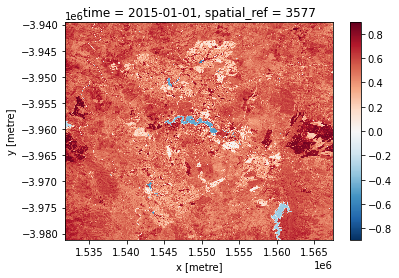

In [5]:
#define Normalised Difference Vegetation Index
NDVI = (ds.nir- ds.red) / (ds.nir+ ds.red)

#plot to visualize 
NDVI.plot()

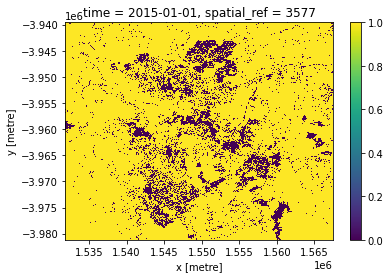

In [6]:
#Define and apply threshold. 

Vegetation_threshold = 0.4 # Modify this to change NDVI threshold 

Vegetated = NDVI >= Vegetation_threshold
Non_Vegetated = NDVI < Vegetation_threshold

#plot to visualize vegetation input layer
Vegetated.plot() #1 = vegetated, 0=not vegetated

### b) Water

Modified Normalised Difference Water Index (MNDWI) (Xu, H. 2006) is the recommended index for identifying open water. With a threshold of 0.

If this notebook is being run over an area of interest that contains significant aquatic vegetation using MNDWI alone may not be sufficient. The mixed water-vegetation signal of aquatic vegetation is difficult to identify in optical remote sensing. The recommended index is the Tasselled Cap Wetness Index (Crist, E.P. 1985). This index does have limitations in non-aquatic areas and so the inclusion of it is only recommended if needed. In order to include use of this index insure the aquatic vegetation flag is switched to true.




In [7]:
#aquatic vegetation floag:

Look_for_aquatic_vegetation = False


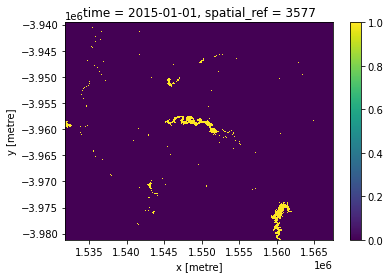

In [8]:
#using the Modified Normalised Difference Water Index

MNDWI = (ds.green- ds.swir1) / (ds.green+ ds.swir1)

if Look_for_aquatic_vegetation == True:
    
    #calculate Tasslled cap wetness to find mixed wet vegatiaion signals
    Wetness_Tasseled = 0.0315 * ds.blue + 0.2021 * ds.green + 0.3102 * ds.red + 0.1594 * ds.nir + (-0.6806 * ds.swir1) + (-0.6109 * ds.swir2)
    
    #define water based on BOTH indexes
    Water = (np.logical_or(MNDWI > 0, Wetness_Tasseled > -200))*1
    Not_Water = (Water == 0)*1
    
else:
    #define water ONLY on MNDWI
    Water = (MNDWI > 0)*1
    Not_Water = (Water == 0)*1
    
Water.plot()

### c) Built Environment

The purpose of this input layer is to differentiate the build environment from natural bare surfaces. These two environments look very similar in optical remote sensing as they are both hard, bright surfaces made from similar components. The suggested index for this input layer is the Modified Built Index (MBI) from Can Trong Nguyen et al 2021 with built areas having a MBI value less than +0.27 and natural bare surfaces having a higher MBI.

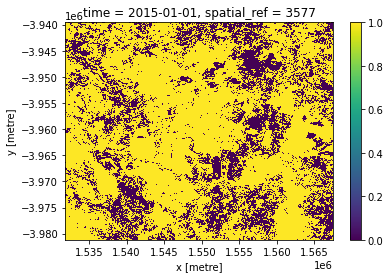

In [9]:
#define Modified Built Index


#calculate MBI
MBI = ((ds.swir1- ds.swir2 - ds.nir) / (ds.swir1+ds.swir2 + ds.nir))+ 0.5  

#apply threshold to MBI
urban =  (MBI < 0.27) * 1

urban.plot()

## Classification




Now that all input layers have been generated they can be used to generate the classification. 

<img src="LCCS_figures/LCCS taxonomy truncated w divisions.jpg">

    Figure 3: truncated level 3 LCCS classification with seperate division steps highlighted

The first division in the classification tree, the split between vegetated and non_vegetated was conducted when NDVI was thresholded in step 2a. the outputs from this division can now be combined with the water input layers to produce the second level of divisions. First we will do the division on the left hand side: dividing Vegitated unto Terrestrial_Veg and Aquatic_Veg:


In [17]:
 # Terrestrial_Veg is defined by where both Vegetation and Not_water are true
Terrestrial_Veg = Vegetated * Not_Water

#Aquatic_veg where there is both vegetation and water
Aquatic_veg = Vegetated * Water 

Next the right hand side of the second division; combining the water input layers with the Non_Vegitated layer.

In [18]:
# where there is Neither vegetation or water
Terrestrial_Non_Veg = Non_Vegetated * Not_Water 

# where there no vegetation but Water is presant
Aquatic = Non_Vegetated * Water


Finally Division three is conducted by combining the Terrestrial_Non_Veg layer with the urban linput layer

In [19]:
#everywhere meets the MBI threshold that is not water or veg
Artificial_Surfaces = Terrestrial_Non_Veg * urban 

#everywhere that is Terrestrial_Non_Veg minus the part classified as Artificial_Surfaces.
Natural_Bare = Terrestrial_Non_Veg - Artificial_Surfaces 

Now that all classifictions have been completed The LCCS class codes can be applied to the classes and the classes combined into one layer. 

In [21]:
#we have no method to differentiate natural from cultivated veg so only using natural codes
Terrestrial_Veg = Terrestrial_Veg * 112

Aquatic_veg = Aquatic_veg * 124

Artificial_Surfaces = Artificial_Surfaces * 215

Natural_Bare = Natural_Bare * 216

Aquatic = Aquatic * 220

LCCS_classes = Terrestrial_Veg + Aquatic_veg + Artificial_Surfaces + Natural_Bare + Aquatic

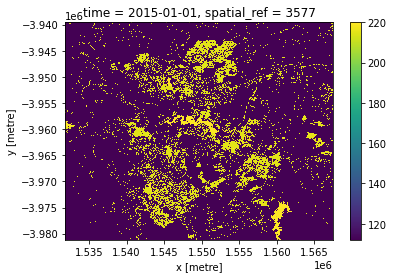

In [22]:
# LCCS_classes.plot()

## Next steps


In [ ]:
# talk about developing other input layers for furthrt classification

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)